In [256]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [205]:
df = pd.read_csv("WebMD Drug Reviews/Dataset/webmd.csv")

In [206]:
df.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


## Data Analysis

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362806 entries, 0 to 362805
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            362806 non-null  object
 1   Condition      362806 non-null  object
 2   Date           362806 non-null  object
 3   Drug           362806 non-null  object
 4   DrugId         362806 non-null  int64 
 5   EaseofUse      362806 non-null  int64 
 6   Effectiveness  362806 non-null  int64 
 7   Reviews        362769 non-null  object
 8   Satisfaction   362806 non-null  int64 
 9   Sex            362806 non-null  object
 10  Sides          362806 non-null  object
 11  UsefulCount    362806 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 33.2+ MB


In [208]:
df.describe()

,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount
count,362806.000000,362806.000000,362806.000000,362806.000000,362806.000000
mean,36879.370774,4.019829,3.532061,3.135408,6.744916
std,52624.412971,1.317711,1.455961,1.611106,9.324240
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,4896.000000,3.000000,3.000000,1.000000,1.000000
50%,9548.000000,5.000000,4.000000,3.000000,4.000000
75%,63522.000000,5.000000,5.000000,5.000000,9.000000
max,178546.000000,10.000000,10.000000,10.000000,255.000000


In [209]:
df.isna().sum()

Age               0
Condition         0
Date              0
Drug              0
DrugId            0
EaseofUse         0
Effectiveness     0
Reviews          37
Satisfaction      0
Sex               0
Sides             0
UsefulCount       0
dtype: int64

In [210]:
df.dropna(inplace=True)

In [211]:
df.Reviews.isna().sum()

0

In [212]:
df = df[:30000]

In [213]:
df.isna().sum()

Age              0
Condition        0
Date             0
Drug             0
DrugId           0
EaseofUse        0
Effectiveness    0
Reviews          0
Satisfaction     0
Sex              0
Sides            0
UsefulCount      0
dtype: int64

In [214]:
for label, content in df.items():
    if (df[label] == ' ').any():
        df = df.loc[df[label] != ' ', :]

In [215]:
for label, content in df.items():
    if (df[label] == " ").any():
        print(label)

In [216]:
df.Age.head(10)

0     75 or over
1          25-34
6          25-34
7          45-54
9          55-64
13         19-24
16         25-34
18         25-34
19         25-34
21         25-34
Name: Age, dtype: object

In [217]:
len(df)

22344

In [218]:
df.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
6,25-34,Birth Control,6/15/2017,wymzya fe,163180,5,5,Haven't gotten pregnant so it does it's job. I...,2,Female,"Nausea , vomiting , headache , bloating , ...",0
7,45-54,Disease of Ovaries with Cysts,1/30/2017,wymzya fe,163180,5,5,I have take this for 5 years age 45-50 to prev...,5,Female,"Nausea , vomiting , headache , bloating , ...",0
9,55-64,Stuffy Nose,10/29/2012,"12 hour nasal relief spray, non-aerosol",9800,4,2,The 12 hour spray only works for me for 6 hours.,2,Male,"Temporary burning, stinging, dryness in the no...",0


In [219]:
df.columns

Index(['Age', 'Condition', 'Date', 'Drug', 'DrugId', 'EaseofUse',
       'Effectiveness', 'Reviews', 'Satisfaction', 'Sex', 'Sides',
       'UsefulCount'],
      dtype='object')

In [220]:
df.drop("DrugId", axis=1, inplace=True)

In [221]:
df.drop(["Reviews", "Sides"], axis=1, inplace=True)

In [222]:
df.head(10)

,Age,Condition,Date,Drug,EaseofUse,Effectiveness,Satisfaction,Sex,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,5,5,5,Male,0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,5,5,5,Female,1
6,25-34,Birth Control,6/15/2017,wymzya fe,5,5,2,Female,0
7,45-54,Disease of Ovaries with Cysts,1/30/2017,wymzya fe,5,5,5,Female,0
9,55-64,Stuffy Nose,10/29/2012,"12 hour nasal relief spray, non-aerosol",4,2,2,Male,0
13,19-24,Birth Control,3/6/2018,lyza,2,3,1,Female,0
16,25-34,Birth Control,10/7/2017,lyza,1,1,1,Female,1
18,25-34,Birth Control,1/30/2017,lyza,5,5,4,Female,1
19,25-34,Birth Control,6/1/2016,lyza,2,5,1,Female,3
21,25-34,Birth Control,4/29/2016,lyza,5,5,4,Female,10


In [223]:
df.isna().sum()

Age              0
Condition        0
Date             0
Drug             0
EaseofUse        0
Effectiveness    0
Satisfaction     0
Sex              0
UsefulCount      0
dtype: int64

## Plotting of the data

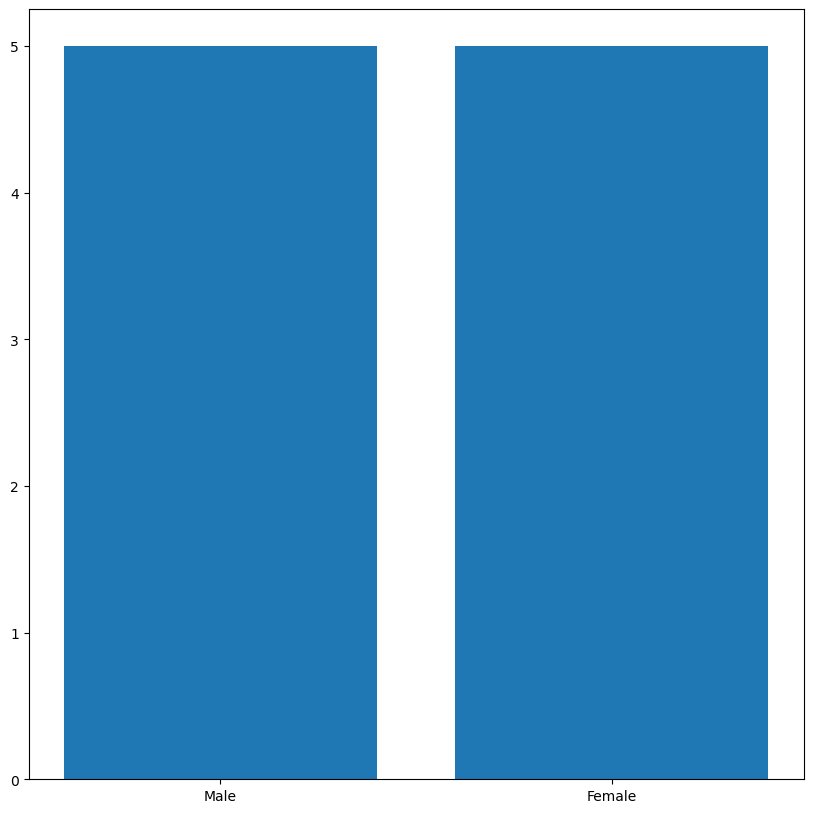

In [157]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(df["Sex"], df["Effectiveness"])
fig.savefig("WedMD Drug Reviews/Images/effectiveness.png")

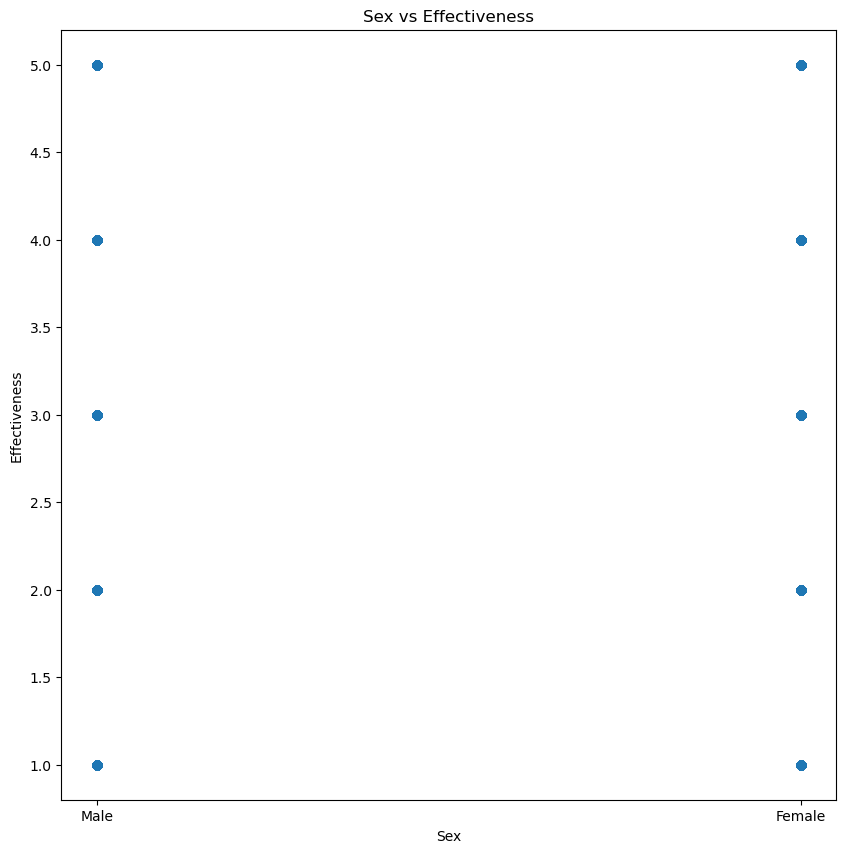

In [158]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df["Sex"], df["Effectiveness"])
ax.set(title="Sex vs Effectiveness",
       xlabel="Sex",
       ylabel="Effectiveness")
fig.savefig("WedMD Drug Reviews/Images/effectiveness2.png")

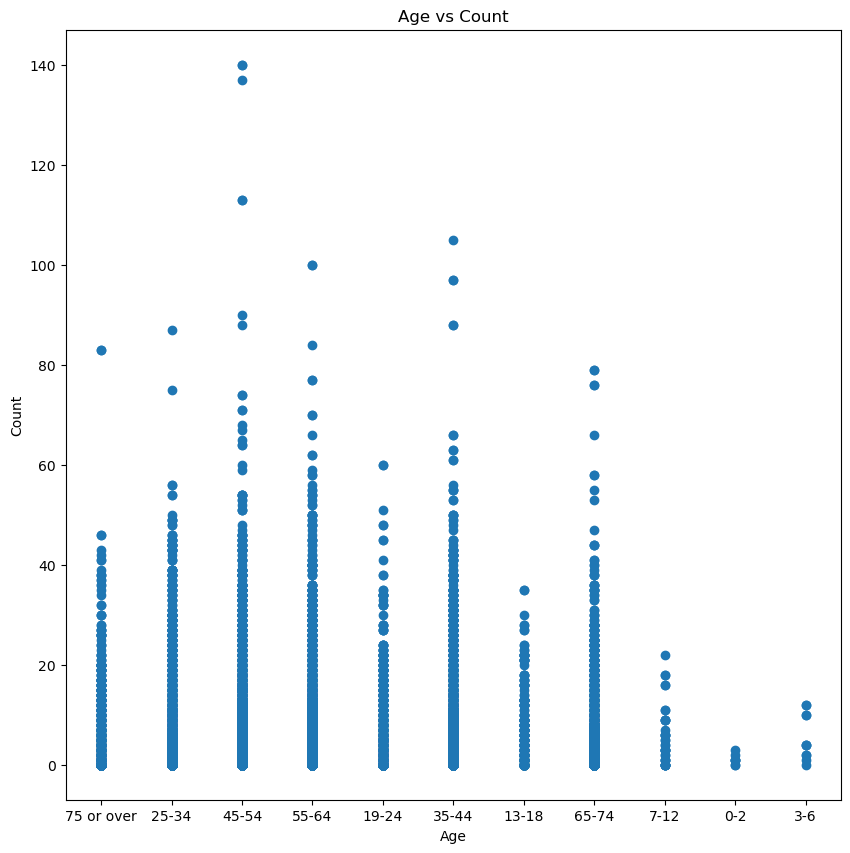

In [162]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df["Age"], df["UsefulCount"])
ax.set(title="Age vs Count",
       xlabel="Age",
       ylabel="Count")
fig.savefig("WedMD Drug Reviews/Images/count.png")

In [161]:
df.head()

,Age,Condition,Date,Drug,EaseofUse,Effectiveness,Satisfaction,Sex,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,5,5,5,Male,0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,5,5,5,Female,1
6,25-34,Birth Control,6/15/2017,wymzya fe,5,5,2,Female,0
7,45-54,Disease of Ovaries with Cysts,1/30/2017,wymzya fe,5,5,5,Female,0
9,55-64,Stuffy Nose,10/29/2012,"12 hour nasal relief spray, non-aerosol",4,2,2,Male,0


C:\Users\Pawas Pandey\AppData\Local\Temp\ipykernel_2212\3018432492.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["Drug"], rotation=60)


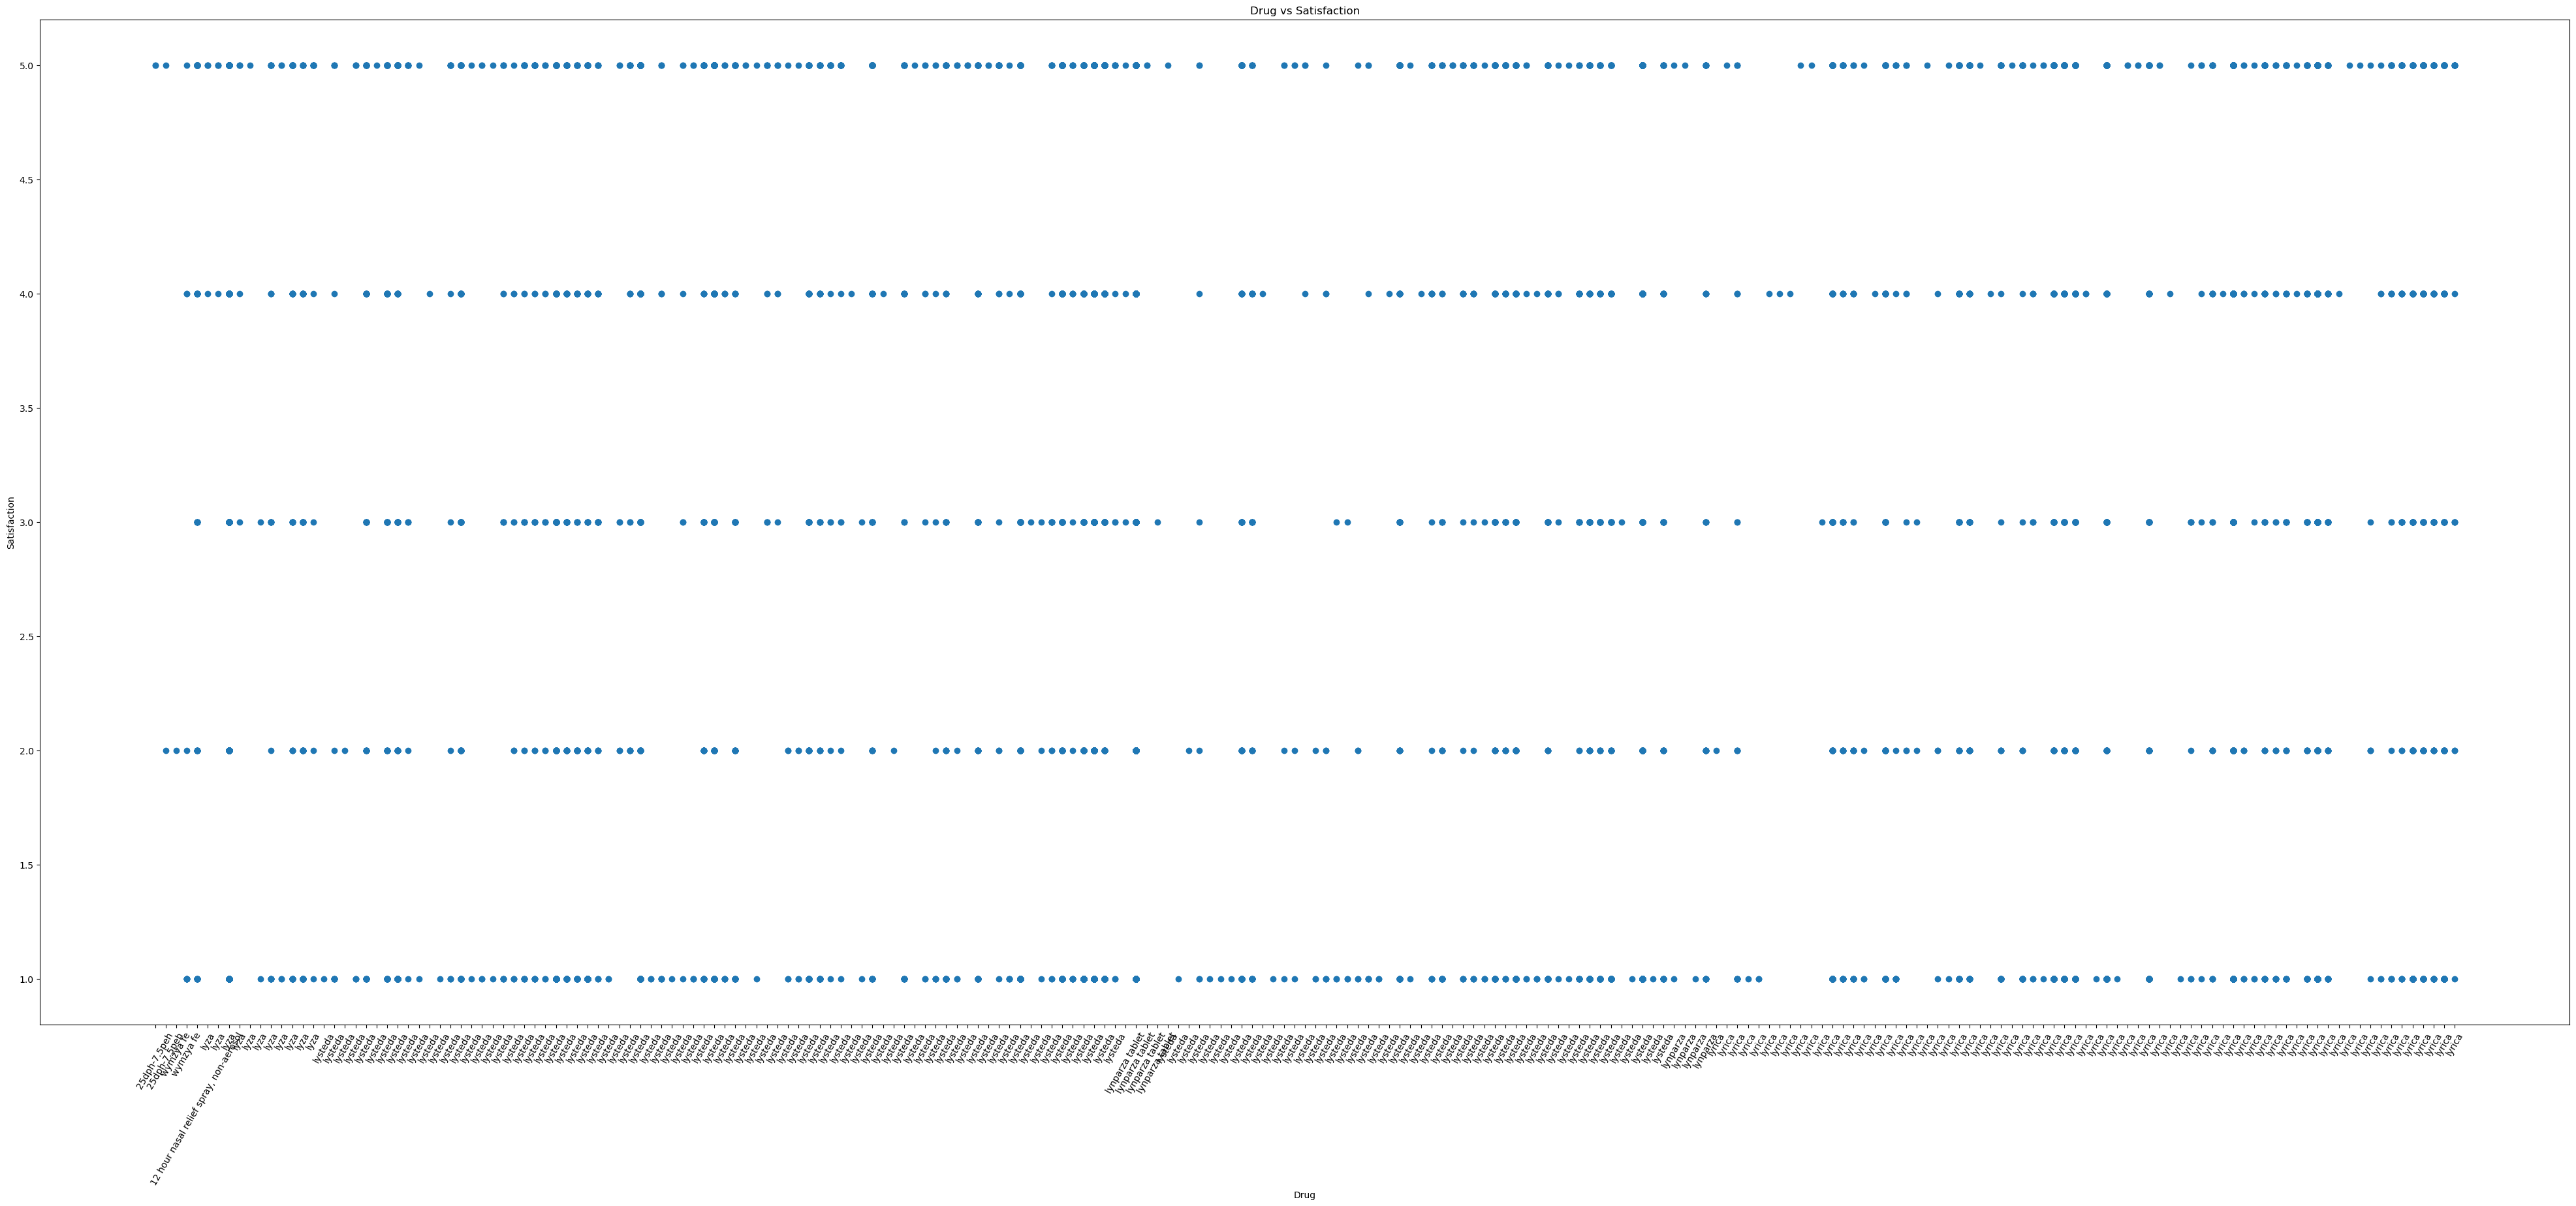

In [168]:
fig, ax = plt.subplots(figsize=(50, 20))
ax.scatter(df["Drug"], df["Satisfaction"])
ax.set(title="Drug vs Satisfaction",
       xlabel="Drug",
       ylabel="Satisfaction")
ax.set_xticklabels(df["Drug"], rotation=60)
fig.savefig("WedMD Drug Reviews/Images/satis.png")

In [169]:
df.Drug.value_counts()

lisinopril solution           3263
lisinopril                    3263
lyrica                        2616
lamictal                      1073
lamictal tablet               1073
                              ... 
lamisil spray, non-aerosol       1
laxative pills tablet            1
lubricant eye drops 0.5 %        1
lohist-d                         1
liquitears drops                 1
Name: Drug, Length: 219, dtype: int64

C:\Users\Pawas Pandey\AppData\Local\Temp\ipykernel_2212\2164670467.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


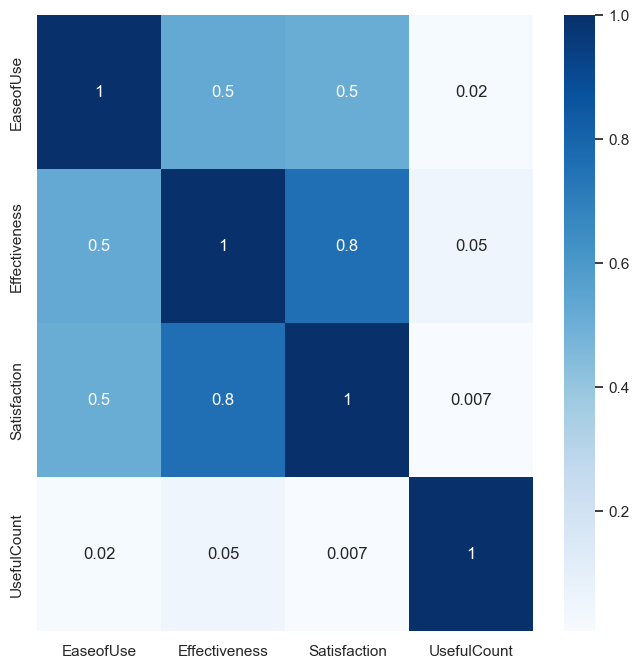

In [175]:
plt.figure(figsize=(8,8))
sns.set_theme(style="white")
corr = df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')
plt.savefig("WedMD Drug Reviews/Images/heatmap.png")

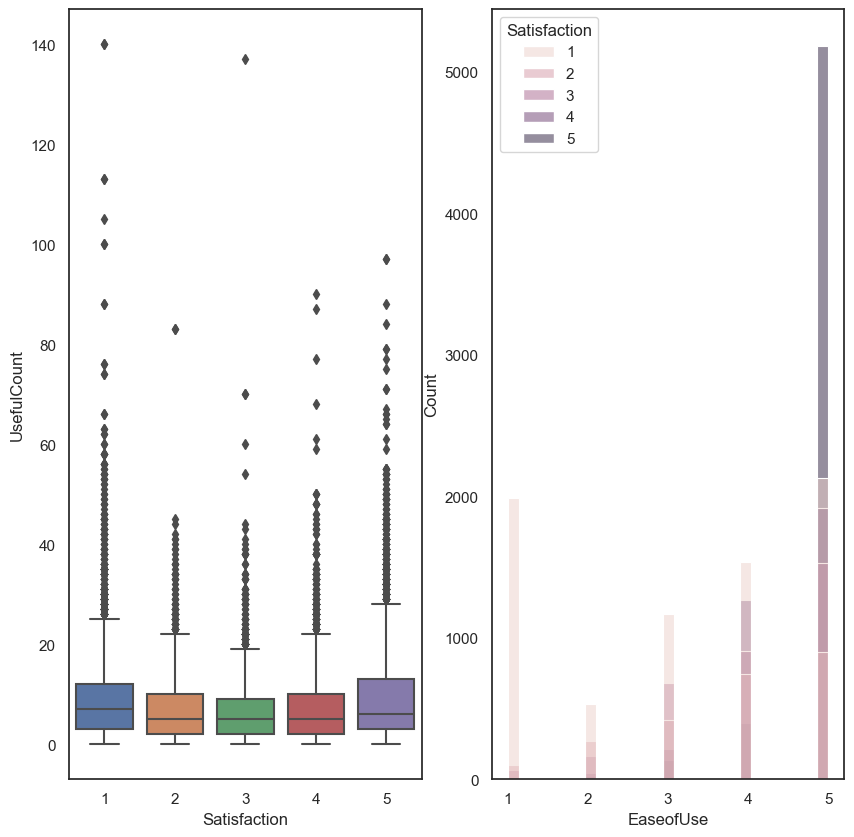

In [181]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
sns.boxplot(ax=ax[0], data=df, x="Satisfaction", y="UsefulCount")
sns.histplot(data=df, x="EaseofUse", hue="Satisfaction")
fig.savefig("WebMD Drug Reviews/Images/hist and boxplot.png")

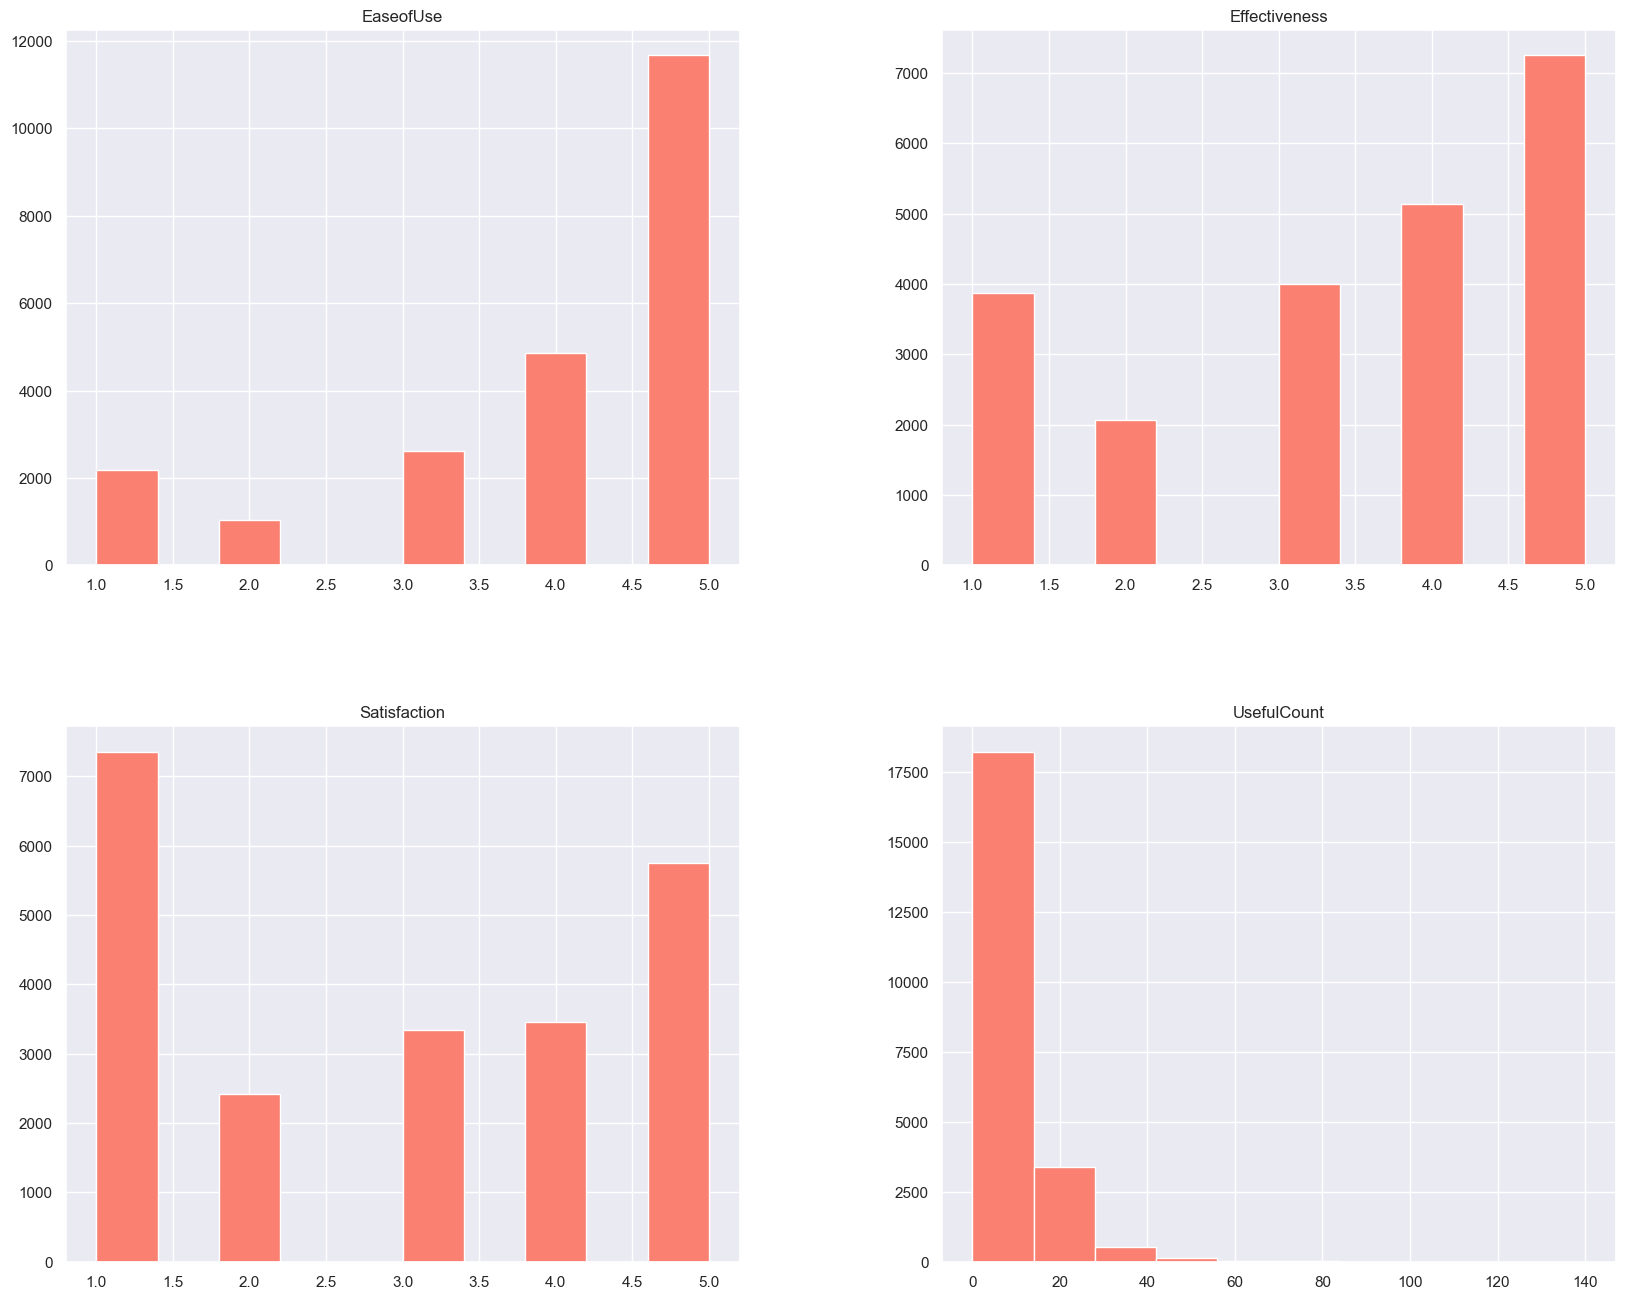

In [183]:
sns.set(rc={"figure.figsize":(20, 16)})
df.hist(color="salmon");
plt.savefig("WebMD Drug Reviews/Images/dataplot.png")

## Data Preprocessing

In [224]:
df.head()

,Age,Condition,Date,Drug,EaseofUse,Effectiveness,Satisfaction,Sex,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,5,5,5,Male,0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,5,5,5,Female,1
6,25-34,Birth Control,6/15/2017,wymzya fe,5,5,2,Female,0
7,45-54,Disease of Ovaries with Cysts,1/30/2017,wymzya fe,5,5,5,Female,0
9,55-64,Stuffy Nose,10/29/2012,"12 hour nasal relief spray, non-aerosol",4,2,2,Male,0


In [225]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Age
Condition
Date
Drug
Sex


In [226]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [227]:
le = LabelEncoder()
df["Sex"] = le.fit_transform(df["Sex"])

In [228]:
df["Sex"]

0        1
1        0
6        0
7        0
9        1
        ..
29999    0
30000    0
30001    1
30002    0
30003    0
Name: Sex, Length: 22344, dtype: int32

In [229]:
df.isna().sum()

Age              0
Condition        0
Date             0
Drug             0
EaseofUse        0
Effectiveness    0
Satisfaction     0
Sex              0
UsefulCount      0
dtype: int64

In [230]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Age
Condition
Date
Drug


In [231]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)
        if label != "Date":
            df[label] = le.fit_transform(df[label])

Age
Condition
Date
Drug


In [232]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Date


In [233]:
df.head()

,Age,Condition,Date,Drug,EaseofUse,Effectiveness,Satisfaction,Sex,UsefulCount
0,10,218,9/21/2014,1,5,5,5,1,0
1,3,45,1/13/2011,1,5,5,5,0,1
6,3,29,6/15/2017,218,5,5,2,0,0
7,6,72,1/30/2017,218,5,5,5,0,0
9,7,218,10/29/2012,0,4,2,2,1,0


In [234]:
df.Drug

0          1
1          1
6        218
7        218
9          0
        ... 
29999     67
30000     62
30001     63
30002     67
30003     62
Name: Drug, Length: 22344, dtype: int32

In [235]:
df.Drug.value_counts()

107    3263
106    3263
207    2616
9      1073
17     1073
       ... 
24        1
59        1
183       1
127       1
103       1
Name: Drug, Length: 219, dtype: int64

In [236]:
df["Date"] = pd.to_datetime(df["Date"])

In [237]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

In [238]:
df["Date"]

0       2014-09-21
1       2011-01-13
6       2017-06-15
7       2017-01-30
9       2012-10-29
           ...    
29999   2009-12-01
30000   2013-08-10
30001   2013-10-22
30002   2009-12-01
30003   2013-08-10
Name: Date, Length: 22344, dtype: datetime64[ns]

In [239]:
df.describe()

,Age,Condition,Drug,EaseofUse,Effectiveness,Satisfaction,Sex,UsefulCount
count,22344.000000,22344.000000,22344.000000,22344.000000,22344.000000,22344.000000,22344.000000,22344.000000
mean,5.795158,101.071608,113.174812,4.020274,3.440387,2.902793,0.275018,8.088033
std,2.018061,56.508290,61.550055,1.304299,1.455983,1.612827,0.446533,8.683595
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5.000000,51.000000,67.000000,3.000000,2.000000,1.000000,0.000000,2.000000
50%,6.000000,101.000000,107.000000,5.000000,4.000000,3.000000,0.000000,6.000000
75%,7.000000,153.000000,160.000000,5.000000,5.000000,5.000000,1.000000,11.000000
max,10.000000,239.000000,218.000000,5.000000,5.000000,5.000000,1.000000,140.000000


## Modelling

In [244]:
X = df.drop(["Effectiveness", "Date"], axis=1)
y = df["Effectiveness"]

In [245]:
X.shape, y.shape

((22344, 7), (22344,))

In [246]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22344 entries, 0 to 30003
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Age            22344 non-null  int32         
 1   Condition      22344 non-null  int32         
 2   Date           22344 non-null  datetime64[ns]
 3   Drug           22344 non-null  int32         
 4   EaseofUse      22344 non-null  int64         
 5   Effectiveness  22344 non-null  int64         
 6   Satisfaction   22344 non-null  int64         
 7   Sex            22344 non-null  int32         
 8   UsefulCount    22344 non-null  int64         
dtypes: datetime64[ns](1), int32(4), int64(4)
memory usage: 1.4 MB


In [249]:
scaled_df_X = pd.DataFrame(scaled_X, columns=X.columns)

In [250]:
scaled_df_X.head()

,Age,Condition,Drug,EaseofUse,Satisfaction,Sex,UsefulCount
0,2.083652,2.069272,-1.822538,0.751168,1.300359,1.623615,-0.931436
1,-1.385102,-0.992294,-1.822538,0.751168,1.300359,-0.615909,-0.816274
2,-1.385102,-1.275445,1.703127,0.751168,-0.559770,-0.615909,-0.931436
3,0.101507,-0.514478,1.703127,0.751168,1.300359,-0.615909,-0.931436
4,0.597043,2.069272,-1.838785,-0.015544,-0.559770,1.623615,-0.931436


In [254]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df_X, y, test_size=0.2)

In [253]:
models = {"Random Forest": RandomForestRegressor(),
          "Gradient Boosting": GradientBoostingRegressor(),
          "SVR": SVR(),
          "Decision Tree": DecisionTreeRegressor(),
          "XGB": XGBRegressor(),
          "LightGBM": LGBMRegressor(),
          "Cat Boost": CatBoostRegressor()}

In [255]:
def metrics_score(y_true, y_pred):
    score = {"Mean Absolute Error": mean_absolute_error(y_true, y_pred),
             "Mean Squared Error": mean_squared_error(y_true, y_pred),
             "Mean Sqaured Root Error": np.sqrt(mean_squared_error(y_true, y_pred)),
             "R2 Score": r2_score(y_true, y_pred)}
    return score

In [259]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} : {metrics_score(y_test, y_pred)}")    

Random Forest : {'Mean Absolute Error': 0.5708711484546354, 'Mean Squared Error': 0.7380668710793606, 'Mean Sqaured Root Error': 0.8591081835714061, 'R2 Score': 0.6569547332041279}
Gradient Boosting : {'Mean Absolute Error': 0.6423456406822693, 'Mean Squared Error': 0.7641177462911534, 'Mean Sqaured Root Error': 0.8741382878533313, 'R2 Score': 0.6448465763589002}
SVR : {'Mean Absolute Error': 0.5977336489084245, 'Mean Squared Error': 0.8270070944197194, 'Mean Sqaured Root Error': 0.9093993041671625, 'R2 Score': 0.6156163073240193}
Decision Tree : {'Mean Absolute Error': 0.5650333692065623, 'Mean Squared Error': 1.0666581734133198, 'Mean Sqaured Root Error': 1.0327914472018636, 'R2 Score': 0.5042291531884443}
XGB : {'Mean Absolute Error': 0.6062397242899468, 'Mean Squared Error': 0.7186697228604131, 'Mean Sqaured Root Error': 0.8477439016946173, 'R2 Score': 0.6659703118008435}
LightGBM : {'Mean Absolute Error': 0.6161346686481047, 'Mean Squared Error': 0.7310591527377345, 'Mean Sqaured 